# APTOS 2019 Blindness Detection

## Circle Crop

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import os
from pathlib import Path
from IPython.display import Image as display_image
from IPython.display import display
print(os.listdir("../input"))

import cv2
from PIL import Image
import imagesize
from scipy import ndimage

['test.csv', 'train.csv', 'sample_submission.csv', 'train_images', 'test_images']


### data load

In [51]:
train_df = pd.read_csv("../input/train.csv")

### define function

In [52]:
def load_image(id):
    print("==============================")
    print("file name\t: {}.png".format(id))
    img_path = Path().absolute().parent / "input" / "train_images" / "{}.png".format(id)
    
    if img_path.exists():
        print("dataset\t\t: train")
        d_level = int(train_df.query("id_code == '{}'".format(id)).iloc[0, 1]) 
        diagnosis_dict = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
        print("diagnosis\t: {} ({})".format(d_level, diagnosis_dict[d_level]))
    else:
        print("dataset\t\t: test")
        img_path = Path().absolute().parent / "input" / "test_images" / "{}.png".format(id)
        
    print("resolution\t: {}".format(imagesize.get(str(img_path))))
    print("==============================")
    return cv2.imread(str(img_path))

In [53]:
def edge_detection(file_name):
    img = load_image(file_name)
    
    dst = cv2.medianBlur(img, ksize=7)
    _b, _g, dst = cv2.split(dst)
    _, dst = cv2.threshold(dst, np.mean(dst)/3, 255, cv2.THRESH_BINARY)
    dst = cv2.Canny(dst, 0, 100)
    dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)

    _, dst = cv2.threshold(dst, 10, 255, cv2.THRESH_BINARY)    
    return dst

### Trial

In [ ]:
# file_name = "00cb6555d108"
# file_name = "005b95c28852"
# file_name = "01499815e469"
file_name = "0167076e7089"

file name	: 0167076e7089.png
dataset		: test
resolution	: (640, 480)
num of edge pixel : 365


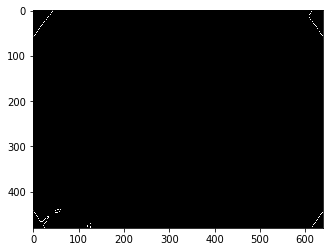

In [54]:
edge = edge_detection(file_name)
plt.imshow(edge)
edge_list = np.where(edge[:, :, 2] == 255)
edge_list = [(edge_list[1][i], edge_list[0][i]) for i in range(len(edge_list[0]))]
print("num of edge pixel : {}".format(len(edge_list)))

In [55]:
def get_center_pixcel(A, B, C, D):
    def get_lineparams(ax, ay, bx, by):
        if (by - ay) == 0:
            by = by + 1
        slope = (ax - bx) / (by - ay)
        section = ((by**2 - ay**2) - (ax**2 - bx**2)) / (2 * (by - ay))
        return slope, section
    
    A_slope, A_section = get_lineparams(A[0], A[1], B[0], B[1])
    B_slope, B_section = get_lineparams(C[0], C[1], D[0], D[1])
    
    if abs(A_slope - B_slope) < 0.01:
        return None, None
    
    X = (B_section - A_section) / (A_slope - B_slope)
    Y = (A_slope * X + A_section + B_slope * X + B_section) / 2
    
    return int(X), int(Y)

Center pixel : (204, 321)
radius : 166


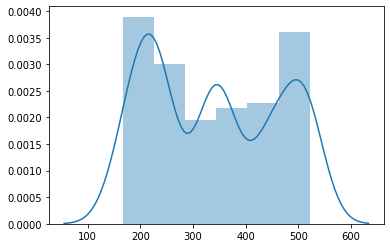

In [68]:
X_cand, Y_cand = [], []
for _ in range(2000):
    edge_sample = [edge_list[i] for i in np.random.randint(0, len(edge_list)-1, 4)]
    x, y = get_center_pixcel(edge_sample[0], edge_sample[1], edge_sample[2], edge_sample[3])
    if x is not None:
        X_cand.append(x)
        Y_cand.append(y)

X, Y = int(np.mean(X_cand)), int(np.mean(Y_cand))
r_list = [np.sqrt((X-e[0])**2+(Y-e[1])**2) for e in edge_list]
radius = int(np.min(r_list))
print("Center pixel : {}".format((X, Y)))
print("radius : {}".format(radius))
sns.distplot(r_list)

In [69]:
def center_crop(img, center, radius):
    height, width, _ = img.shape
    mask = np.zeros((height, width), np.uint8)
    
    mask = cv2.circle(mask, center, radius, (255, 255, 255), thickness=-1)
    mask_img = cv2.bitwise_and(img, img, mask=mask)
    
    result = np.vstack((img, mask_img))
    plt.figure(figsize=(5, 10))
    plt.imshow(result)
    
    crop_img = np.zeros((radius*2, radius*2, 3), np.uint8)
    cl, cr, ct, cb = 0, radius*2, 0, radius*2
    il, ir, it, ib = 0, width, 0, height
    if center[1] - radius > 0:
        it = center[1] - radius
    else:
        ct = radius - center[1]
        
    if height - center[1] > radius:
        ib -= (height - center[1]) - radius
    else:
        cb -= radius - (height - center[1])
        
    if center[0] - radius > 0:
        il = center[0] - radius
    else:
        cl = radius - center[0]
    
    if width - center[0] > radius:
        ir -= (width - center[0]) - radius
    else:
        cr -= radius - (width - center[0])
    
    crop_img[ct:cb, cl:cr, :] = mask_img[it:ib, il:ir, :]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(crop_img)

file name	: 0167076e7089.png
dataset		: test
resolution	: (640, 480)


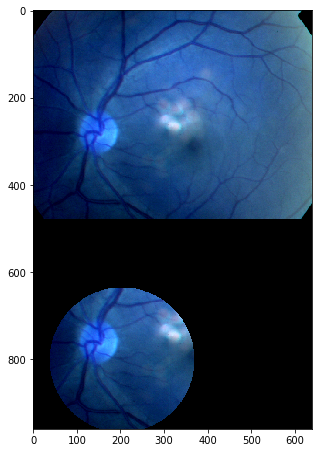

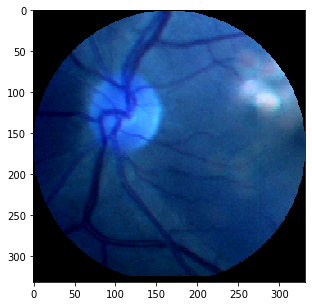

In [70]:
center_crop(load_image(file_name), (X, Y), radius)